In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import pearsonr
import genome_model
# import seaborn
# seaborn.set()
from importlib import reload
reload(genome_model)
simple_model = genome_model.simple_model

In [2]:
def upper_bound(threshold, read_length, coverage, number_of_reads):
    return float(read_length*(1-(1/coverage)*math.log(number_of_reads/threshold)))

upper_bound_vect = np.vectorize(upper_bound, excluded=['threshold', 'read_length'])

In [3]:
def upper_bound_unitigs(k, l, N, c):
    return N * np.exp(-c*(1-k/l))
upper_bound_unitigs_vect = np.vectorize(upper_bound_unitigs, excluded=['l'])

In [4]:
all_data = pd.read_csv('model_fit_data.tsv', sep='\t', index_col=0)
all_data['num of reads'] = all_data['coverage'] * 309440/20
all_data['Sample Num'] = all_data.index.map(lambda x: int(x.split('_')[len(x.strip('-contigs').split('_'))-1]))

In [5]:
all_data['Upper Bound on Unitigs'] = all_data.apply(lambda row: upper_bound_unitigs(row['k'], 150, row['num of reads'], row['coverage']), axis=1)

In [6]:
all_data['haploid_content'] = all_data['N1']/all_data['F1']

In [7]:
SMALL_SIZE = 18
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Regression 

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [9]:
# all_data = all_data[(all_data['coverage'] == 20) &
#                         (all_data['fragment_length'] == 200) &
#                         (all_data['Sample Num'] <= 4)]

In [10]:
X = all_data[['haploid_content', 'error_content', 'repeat_content', 'Upper Bound on Unitigs']]
y = all_data['# contigs']

In [11]:
((all_data['Sample Num'] <=4) & (all_data['fragment_length'] == 200) & (all_data['coverage'] == 20)).any()

True

In [12]:
# Test train split
# split = 3
# X_train = X[all_data['Sample Num'] <= split]
# X_test = X[all_data['Sample Num'] > split]
# y_train = y[all_data['Sample Num'] <= split]
# y_test = y[all_data['Sample Num'] > split]

In [13]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
y_hat = lin_reg.predict(X)
lin_reg.score(X, y)

0.69621553975370642

In [14]:
# plt.figure(figsize=(20,10))
# plt.plot(partial_data['k'],  partial_data['Repeat Content'], 'b.')
# plt.plot(partial_data['k'],  partial_data['N1'], 'g.')
# plt.show()

In [15]:
# svm_reg = SVR(kernel='linear')
# svm_reg.fit(X_train, y_train)
# svm_reg.score(X_test, y_test)

In [16]:
rfr = RandomForestRegressor(n_estimators=10)
rfr.fit(X, y)
y_hat_rfr = rfr.predict(X)
rfr.score(X, y)

0.9851169658000587

In [17]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
y_hat = lin_reg.predict(X)
print(lin_reg.score(X, y))
pearsonr(lin_reg.predict(X), y)

0.696215539754


(0.83439531383733589, 8.8763348429613704e-71)

In [30]:
lin_reg.coef_

array([  4.22166528e+04,  -6.62440299e+01,   3.80340746e+04,
         1.96758303e-01])

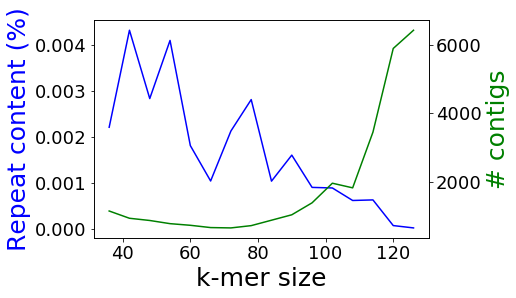

In [18]:
# Show for one sample
# sample = "ecoli_20X_4
# plt.figure(figsize=(20,10))
fig, ax1 = plt.subplots()

names = ["k{}_ecoli_20X_1".format(i) for i in range(36, 127, 6)] # + ["k{}_ecoli_20X_noerr_2".format(i) for i in range(36, 127, 6)] + ["k{}_ecoli_20X_noerr_3".format(i) for i in range(36, 127, 6)] + ["k{}_ecoli_20X_noerr_4".format(i) for i in range(36, 127, 6)]
repeat_content = all_data.loc[names, 'repeat_content']
ng50 = all_data.loc[names, 'NG50']
num_contigs = all_data.loc[names, '# contigs (>= 0 bp)']
x = all_data.loc[names, 'k']

ax1.plot(x, repeat_content, 'b-')
ax1.set_ylabel('Repeat content (%)', color='b')
ax1.set_xlabel('k-mer size', color='black')
ax2 = ax1.twinx()
#ax1.plot(x, ng50, 'b.')
#ax1.set_ylabel('NG50', color='b')
#ax2 = ax1.twinx()

ax2.plot(x, num_contigs, 'g-')
ax2.set_ylabel('# contigs', color='g')


plt.show()

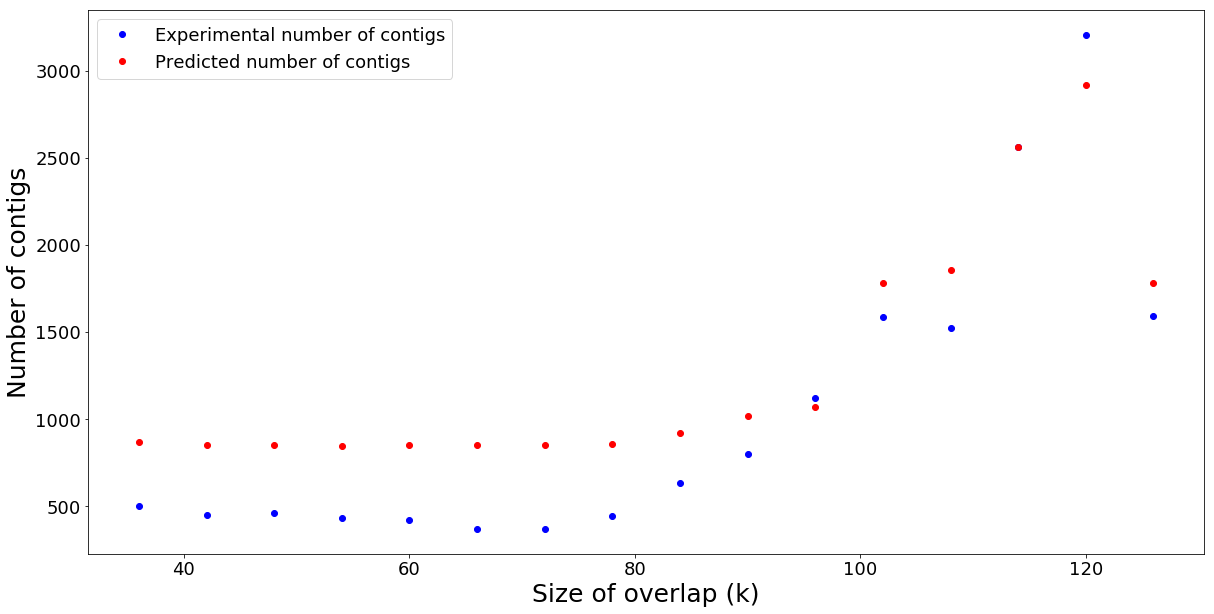

In [29]:
plt.figure(figsize=(20,10))

x = all_data.loc[names, 'k']
num_contigs = all_data.loc[names, '# contigs']
pred = rfr.predict(all_data.loc[names, ['N1', 'error_content', 'repeat_content', 'Upper Bound on Unitigs']])# [mask]

# filtered_exp = lowess(num_contigs, x, frac=0.5)
# filtered_pred = lowess(pred, x, frac=0.5)


# plt.plot(filtered[:, 0], filtered_exp[:, 1], 'b--', linewidth=3, label='LOWESS over exp. contigs')
# plt.plot(filtered_pred[:, 0], filtered_pred[:, 1], 'r--', linewidth=3, label='LOWESS over pred. contigs')
plt.plot(x, num_contigs, 'bo', label='Experimental number of contigs')
plt.plot(x, pred, 'ro', label='Predicted number of contigs')
plt.legend()
plt.xlabel('Size of overlap (k)')
plt.ylabel('Number of contigs')

# plt.savefig('/Users/emreerhan/Desktop/thesis/model_eval.png')
plt.show()

In [20]:
num_contigs

k36_ecoli_20X_1      503
k42_ecoli_20X_1      448
k48_ecoli_20X_1      463
k54_ecoli_20X_1      434
k60_ecoli_20X_1      418
k66_ecoli_20X_1      370
k72_ecoli_20X_1      368
k78_ecoli_20X_1      444
k84_ecoli_20X_1      632
k90_ecoli_20X_1      797
k96_ecoli_20X_1     1122
k102_ecoli_20X_1    1586
k108_ecoli_20X_1    1525
k114_ecoli_20X_1    2564
k120_ecoli_20X_1    3205
k126_ecoli_20X_1    1592
Name: # contigs, dtype: int64

In [32]:
xdata = np.arange(60, 140, 0.25)
ydata1 = upper_bound_unitigs_vect(xdata, 150, 309440, 20) + 1
ydata2 = upper_bound_unitigs_vect(xdata, 150, 773600, 50) + 1
ydata3 = upper_bound_unitigs_vect(xdata, 150, 1547200, 100) + 1
plt.figure('Expected number of contigs for 3 sequencing experiments on E. coli', figsize=(20,10))
plt.ylabel('log(Expected Num. Contigs))')
plt.xlabel('k-mer size')
plt.plot(xdata, np.log(ydata1), 'b-', label='20X coverage')
plt.plot(xdata, np.log(ydata2), 'r-', label='50X coverage')
plt.plot(xdata, np.log(ydata3), 'g-', label='100X coverage')
plt.legend()
# plt.show()
plt.savefig('expected_num_contigs.png')

# Human

In [22]:
human_data = pd.read_csv('human_model_fit.tsv', sep='\t', index_col=0)
human_data['Upper Bound on Unitigs'] = human_data.apply(lambda row: upper_bound_unitigs(row['k'], 150, 800000000, 40), axis=1)

In [23]:
human_data['haploid_content'] = human_data['N1']/human_data['F0']

In [28]:
X = human_data[['haploid_content', 'error_content', 'repeat_content', 'Upper Bound on Unitigs']]
y = human_data['# contigs']
print(pearsonr(lin_reg.predict(X), y))
lin_reg.score(X, y)

(-0.091788946695513157, 0.82885995813375568)


-3.6225970569537997

In [25]:
human_data['# contigs']

0    1002028
1      13428
2    1099322
3    1024664
4     815016
5     639411
6     458079
7     367405
Name: # contigs, dtype: int64

In [26]:
lin_reg.predict(X)

array([ 2611.93080571,  1483.19468676,   977.97888688,   856.20434552,
         925.05022418,  1030.98411271,  1295.55047118,  1674.9030423 ])

In [40]:
all_data[['k', 'F0']].sort_values('k')

,k,F0
k30_ecoli_200X_4,30,70585124
k30_ecoli_100X_3,30,38778709
k30_ecoli_20X_4,30,11674109
k30_ecoli_100X_1,30,38826753
k30_ecoli_20X_2,30,11670330
k30_ecoli_20X_1,30,11593927
k30_ecoli_100X_4,30,38886151
k30_ecoli_200X_1,30,70778944
k30_ecoli_20X_3,30,11661941
k30_ecoli_100X_2,30,38794937
